<a href="https://colab.research.google.com/github/vitfrncs/LiPAI_board/blob/master/src/semana_8/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torch.optim import Adam
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Treinando em: {device}")

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Treinando em: cuda


In [2]:
# Mudando o dataset para Fashion-MNIST
root_path = '/home/storopoli/Downloads'
train_dataset = torchvision.datasets.FashionMNIST(root=root_path, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root=root_path, train=False, transform=trans)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.2MB/s]


In [3]:
batch_size = 32
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(7 * 7 * 64, 1000),
            nn.ReLU())
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = ConvNet().to(device)

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 6

In [6]:
best_val_acc = 0.0
best_model_path = "fashion_best_model.pth"

train_loss_list, train_acc_list = [], []
valid_loss_list, valid_acc_list = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    total, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss_list.append(running_loss / total)
    train_acc_list.append(100 * correct / total)

    # Validação
    model.eval()
    val_loss, val_total, val_correct = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = 100 * val_correct / val_total
    valid_loss_list.append(val_loss)
    valid_acc_list.append(val_acc)

    print(f"Época {epoch+1}: acc: {val_acc:.2f}%, loss: {val_loss:.4f}")

    # Salvar melhor modelo
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f">>> Novo melhor modelo salvo com acc={best_val_acc:.2f}%")


Época 1: acc: 89.37%, loss: 0.2907
>>> Novo melhor modelo salvo com acc=89.37%
Época 2: acc: 90.62%, loss: 0.2496
>>> Novo melhor modelo salvo com acc=90.62%
Época 3: acc: 91.27%, loss: 0.2386
>>> Novo melhor modelo salvo com acc=91.27%
Época 4: acc: 91.92%, loss: 0.2313
>>> Novo melhor modelo salvo com acc=91.92%
Época 5: acc: 91.24%, loss: 0.2676
Época 6: acc: 91.86%, loss: 0.2700


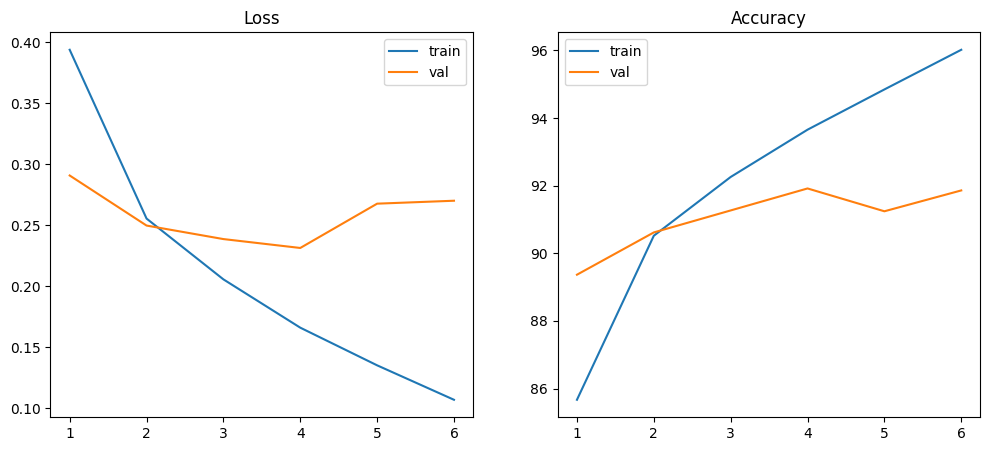

In [7]:
epochs_list = list(range(1, epochs+1))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_list, train_loss_list, label="train")
plt.plot(epochs_list, valid_loss_list, label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_list, train_acc_list, label="train")
plt.plot(epochs_list, valid_acc_list, label="val")
plt.title("Accuracy")
plt.legend()
plt.show()


In [9]:
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Acurácia final no Fashion-MNIST: {round(100*correct/total, 2)}%")

Acurácia final no Fashion-MNIST: 90.58%
